# From transfer function to difference equation
In approximately the middle of Peter Corke's lecture [Introduction to digital control](https://youtu.be/XuR3QKVtx-g?t=34m56s), he explaines how to go from a transfer function description of a controller (or compensator) to a difference equation that can be implemented on a microcontroller. 

The idea is to recognize that the term $$ sX(s) $$ in a transfer function is the laplace transform of the derivative of $x(t)$, 
\begin{equation}
sX(s) + x(0) \quad \overset{\mathcal{L}}{\longleftrightarrow} \quad \frac{d}{dt} x(t),
\end{equation}
where the inital value $x(0)$ is often taken to be zero. We then make use of a discrete approximation of the derivative 
$$ \frac{d}{dt}x(t) \approx \frac{x(t-h) - x(t)}{h}, $$
where $h$ is the time between the samples in the sampled version of signal $x(t)$. 

The steps to convert the system on transfer function form
$$ Y(s) = F(s)U(s) = \frac{s+b}{s+a}U(s) $$
are to write
$$ (s+a)Y(s) = (s+b)U(s) $$
$$ sY(s) + aY(s) = sU(s) + bU(s), $$
take the inverse Laplace transform
$$ \frac{d}{dt} y + ay = \frac{d}{dt} u + bu$$
and use the discrete approximation of the derivative
$$ \frac{y_k - y_{k-1}}{h} + ay_k = \frac{u_k - u_{k-1}}{h} + bu_k $$
which can be written
$$ (1+ah) y_k = y_{k-1} + u_k - u_{k-1} + bh u_k,$$
or
$$ y_k = \frac{1}{1+ah} y_{k-1} + \frac{1+bh}{1+ah}u_k - \frac{1}{1+ah}u_{k-1}. $$


## Example
With the system
$$ F(s) =  \frac{s+1}{s+2} $$ 
and the sampling time
$$ h=0.1 $$
we get the difference equation
$$ y_k = \frac{1}{1.2}y_{k-1} + \frac{1.1}{1.2}u_k - \frac{1}{1.2} u_{k-1}. $$

Let's implement the system and see how the discrete approximation compares to the continuous-time system for the case of a step-response.

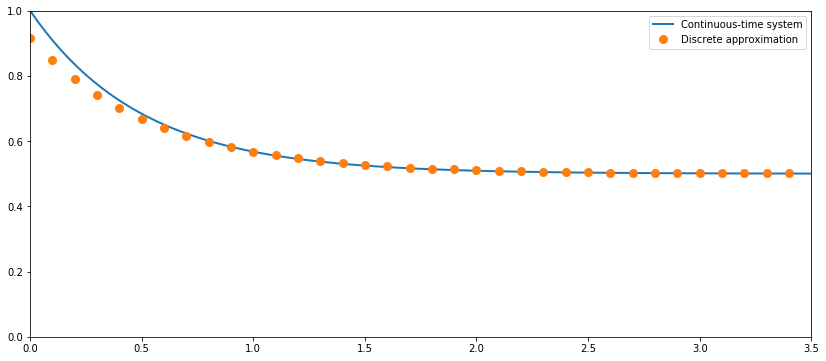

In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
%matplotlib inline

# Define the continuous-time linear time invariant system F
a = 2
b = 1
num = [1, b]
den = [1, a]
F = signal.lti(num, den)

# Plot a step response
(t, y) = signal.step(F)
plt.figure(figsize=(14,6))
plt.plot(t, y, linewidth=2)

# Solve the difference equation y_k = c y_{k-1} + d_0 u_k + d_1 u_{k-1}
h = 0.1 # The sampling time

c = 1.0/(1 + a*h)
d0 = (1 + b*h) / (1 + a*h)
d1 = -c

td = np.arange(35)* h #The sampling time instants
ud = np.ones(35) # The input signal is a step, limited in time to 3.5 seconds
yd = np.zeros(35) # A vector to hold the discrete output signal
yd[0] = c*0 + d0*ud[0] - d1*0 # The first sample of the output signal
for k in range(1,35): # And then the rest
    yd[k] = c*yd[k-1] + d0*ud[k] + d1*ud[k-1]
    
plt.plot(td, yd, 'o', markersize=8)
plt.xlim([0, 3.5])
plt.ylim([0, 1])
plt.legend(('Continuous-time system', 'Discrete approximation'))

## Exercise
1. Why is the error in the discrete approximation larger in the beginning than at the end of the step-response?
2. Make a discrete approximation of the transfer function $$ F(s) = \frac{3}{s+3} $$ using the sampling time $$ h=0.2 $$ Then simulate and plot a step-response for the continuous- and discrete system, following the example above. *Hint*: Copy the python code for the example above into the code cell below and modify for the exercise.

In [ ]:
## Your python code goes here

# Recursively computing values of a polynomial using difference equations
In the lecture by Peter Corke, he talks about the historical importance of difference equations for computing values of a polynomial. Let's look at this in some more detail.

## A first order polynomial
Consider the polynomial
$$ p(x) =  4x + 2. $$
The first difference is
$$ \Delta p(x) = p(x) - p(x-h) = 4x + 2 - \big( 4(x-h) + 2 \big) = 4h, $$
and the second order difference is zero (as are all higher order differences):
$$ \Delta^2 p(x) = \Delta p(x) - \Delta p(x-h) = 4h - 4h = 0. $$

Using the firs order difference, we can also write the second order difference $ \Delta p(x) - \Delta p(x-h) = \Delta^2 p(x) $
as
$$ p(x) - p(x-h) - \Delta p(x-h) = \Delta^2p(x) $$
or
$$ p(x) = p(x-h) + \Delta p(x-h) + \Delta^2 p(x)$$
which for the first order polynomial above becomes
$$ p(x) = p(x-h) + \Delta p(x-h) = p(x-h) + 4h. $$

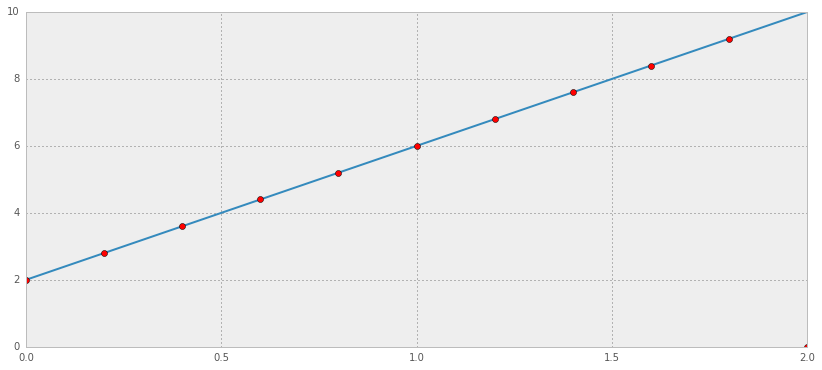

In [10]:
def p1(x): return 4*x + 2 # Our first-order polynomial
# Compute values for x=[0,0.2, 0.4, ... 2] recursively using the difference equation
h = 0.2
x = h*np.arange(11) # Gives the array [0,0.2, 0.4, ... 2]
pd = np.zeros(11)
d1 = 4*h

# Need to compute the first value as the initial value for the difference equation,
pd[0] = p1(x[0])

for k in range(1,10): # Solve difference equation
    pd[k] = pd[k-1] + d1

plt.figure(figsize=(14,6))
plt.plot(x, p1(x), linewidth=2)
plt.plot(x, pd, 'ro')

## Second order polynomial
For a second order polynomial 
$$ p(x) = a_0x^2 + a_1x + a_2 $$
we have
$$ p''(x) = 2a_0, $$
and the differences
$$ \Delta p(x) = p(x) - p(x-h) = a_0x^2 + a_1x + a_2 - \big( a_0(x-h)^2 + a_1(x-h) + a_2 \big) = h(2a_0x + a_1) -a_0h^2, $$
$$ \Delta^2 p(x) = \Delta p(x) - \Delta p(x-h) = h(2a_0x+a_1) - a_0h^2 - \big( h(2a_0(x-h) + a_1) - a_0 h^2 \big) =  h^22a_0 $$

Recall the difference equation using the second order difference
$$ p(x) = p(x-h) + \Delta p(x-h) + \Delta^2 p(x)$$
We now get
$$ p(x) = p(x-h) + \Delta p(x-h) + \Delta^2 p(x) = p(x-h) + \Delta p(x-h) + h^2 2 a_0,$$
or, using the definition of the first-order difference $\Delta p(x-h)$ 
$$ p(x) = 2p(x-h) - p(x-2h) + h^2 2 a_0,$$

Consider the second order polynomial
$$ p(x) = 2x^2 - 3x + 2, $$
and compute values using the difference equation.
 

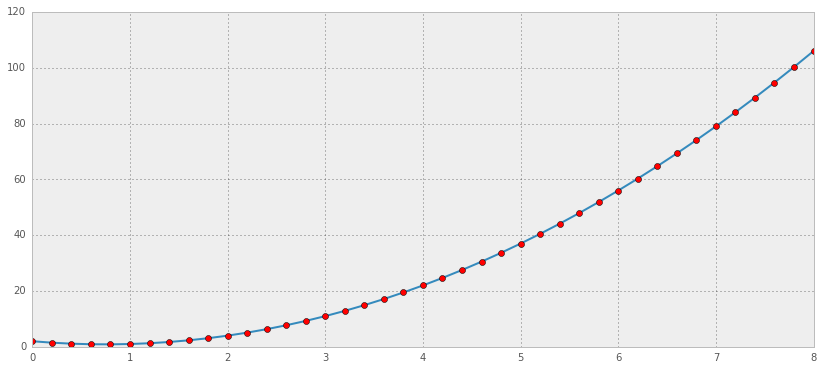

In [38]:
a0 = 2
a1 = -3
a2 = 2
def p2(x): return a0*x**2 + a1*x + a2 # Our second-order polynomial

# Compute values for x=[0,0.2, 0.4, ... 8] recursively using the difference equation
h = 0.2
x = h*np.arange(41) # Gives the array [0,0.2, 0.4, ... 2]
d1 = np.zeros(41) # The first differences
pd = np.zeros(41)
d2 = h**2*2*a0 # The constant, second difference

# Need to compute the first two values to get the initial values for the difference equation,
pd[0] = p2(x[0])
pd[1] = p2(x[1])

for k in range(2,41): # Solve difference equation
    pd[k] = 2*pd[k-1] - pd[k-2] + d2
    
plt.figure(figsize=(14,6))
plt.plot(x, p2(x), linewidth=2) # Evaluating the polynomial
plt.plot(x, pd, 'ro') # The solution using the difference equation

## Exercise
What order would the difference equation be for computing valuse of a third-order polynomial? What is the difference equation?